# Bu Tweet Hangi Politik Lidere Ait?

Takvimler şu an 27 Temmuz 2020'yi göstermekte. Ülkece atlattığımız son seçim 31 Mart 2019 tarihinde idi. O tarihten bu yana (seçim günü hariç), Türkiye siyasi partilerinden Ak Parti Genel Başkanı ve Türkiye Cumhurbaşkanı Recep Tayyip Erdoğan ile Cumhuriyetçi Halk Partisi Genel Başkanı Kemal Kılıçdaroğlu tarafından atılmış olan herkese açık Tweet'leri twint modülünü kullanarak scrapeledim. Modül hakkında daha fazla bilgi için [buraya](https://github.com/twintproject/twint/wiki) tıklayabilirsiniz. Scraping scriptimi (get_tweets.py) bu repoda bulabilirsiniz.

#### Özetle, bu projede makine öğrenimi yoluyla Tweetlerin kim tarafından paylaşıldığını tahmin eden bir sınıflandırıcı yapacağız. Daha detaylı bilgiyi devam eden başlıklarda ve açıklamalarda sunacağım.

Elimizdeki veri metin verisi, her iki partinin genel başkanının şu ana kadar atmış oldukları Tweetlere dair bilgiler içermekte.

Verilerin yapılandırması şu şekilde:
* id: Tweetlerin özgün kimlik numaraları
* created_at: Tweetlerin atılma zamanı
* username: Tweet sahibinin kullanıcı ismi
* tweet: Tweet içeriği (metin)
* mentions: Etiketlenen Twitter kullanıcılarının kullanıcı isimleri
* likes_count: Tweet'in aldığı like sayısı
* retweet: Tweet Retweet mi değil mi? (Boolean)
* hashtags: Kullanılan etiketlerin listesi

Önce kullanacağımız modülleri ve elimizdeki verileri içe aktararak başlayalım:

# 1. Verileri İçe Aktarma ve Keşfetme

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
rte_tweetleri = pd.read_csv("RTErdogan.csv")
kk_tweetleri = pd.read_csv("kilicdarogluk.csv")

#İşlem kolaylığı için verileri tek veri setinde toplayacağız:
twt = pd.concat([rte_tweetleri, kk_tweetleri])

twt.head()

,id,created_at,username,tweet,mentions,likes_count,retweet,hashtags
0,1287361340080828418,1595765836000,rterdogan,Millî İstihbarat Teşkilatı İstanbul Bölge Başk...,[],42189,False,[]
1,1287043591479664641,1595690078000,rterdogan,Eserleriyle tarihe ışık tutan “hocaların hocas...,[],50113,False,[]
2,1287016078334398464,1595683519000,rterdogan,Türkiye Cumhuriyeti Devleti'ni kuruluşunun 100...,[],36765,False,[]
3,1286989390846267393,1595677156000,rterdogan,Amasya Çevre Yolu Açılış Töreni’ne canlı bağla...,[],33986,False,[]
4,1286603362256003073,1595585120000,rterdogan,İlk cuma namazı @AyasofyaCamii https://twitter...,['ayasofyacamii'],121117,False,[]


In [3]:
twt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267 entries, 0 to 397
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1267 non-null   int64 
 1   created_at   1267 non-null   int64 
 2   username     1267 non-null   object
 3   tweet        1267 non-null   object
 4   mentions     1267 non-null   object
 5   likes_count  1267 non-null   int64 
 6   retweet      1267 non-null   bool  
 7   hashtags     1267 non-null   object
dtypes: bool(1), int64(3), object(4)
memory usage: 80.4+ KB


Gördüğümüz üzere hiç eksik verimiz yok. Verilerimizin üzerinde çalışmaya başlayabiliriz.

# 2. Verilerin İşlenmesi

Verilerimizi makine öğrenimi uygulamadan önce temizleyip işlemek zorundayız. Buna "created_at" sütunundan başlayacağız. Projemize girişte bu sütunun Tweetlerin atıldığı zamanı belirttiğini söylemiştik. Oysa sütunumuz şu an integer tipinde. Sütunumuzu daha anlaşılır hale getirmek için datetime tipine çevireceğiz. Sonrasında da "id" sütunumuzu "tweet_id" şeklinde yeniden isimlendireceğiz.

In [4]:
twt.created_at = pd.to_datetime(twt.created_at, unit="ms").dt.date #zaman birimi default olarak "ns" ayarlıdır, bu yüzden "ms" olarak belirttik.
twt.created_at.tail()

393    2019-04-12
394    2019-04-09
395    2019-04-08
396    2019-04-03
397    2019-04-02
Name: created_at, dtype: object

In [5]:
twt.rename({"id": "tweet_id"}, axis=1, inplace=True)
twt.head()

,tweet_id,created_at,username,tweet,mentions,likes_count,retweet,hashtags
0,1287361340080828418,2020-07-26,rterdogan,Millî İstihbarat Teşkilatı İstanbul Bölge Başk...,[],42189,False,[]
1,1287043591479664641,2020-07-25,rterdogan,Eserleriyle tarihe ışık tutan “hocaların hocas...,[],50113,False,[]
2,1287016078334398464,2020-07-25,rterdogan,Türkiye Cumhuriyeti Devleti'ni kuruluşunun 100...,[],36765,False,[]
3,1286989390846267393,2020-07-25,rterdogan,Amasya Çevre Yolu Açılış Töreni’ne canlı bağla...,[],33986,False,[]
4,1286603362256003073,2020-07-24,rterdogan,İlk cuma namazı @AyasofyaCamii https://twitter...,['ayasofyacamii'],121117,False,[]


Verilerimizi şimdilik yeterince temizledik. Elimizdeki veri zaten çok sınırlı olduğu için ve hiç eksik bilgi içermediği için verilerimizi görselleştirip analiz edebiliriz.

# 3. Verilerin Görselleştirilmesi ve Analizi

Verilerimizi görselleştirmeye her iki siyasi figürün de farklı tarihlerde atmış oldukları Tweet sayıları ile başlayacağız. Bunu yapmak için de Tweetleri atıldıkları tarihe ve ait oldukları politik lidere göre gruplayacağız.

Text(0, 0.5, 'Tweet Miktarı')

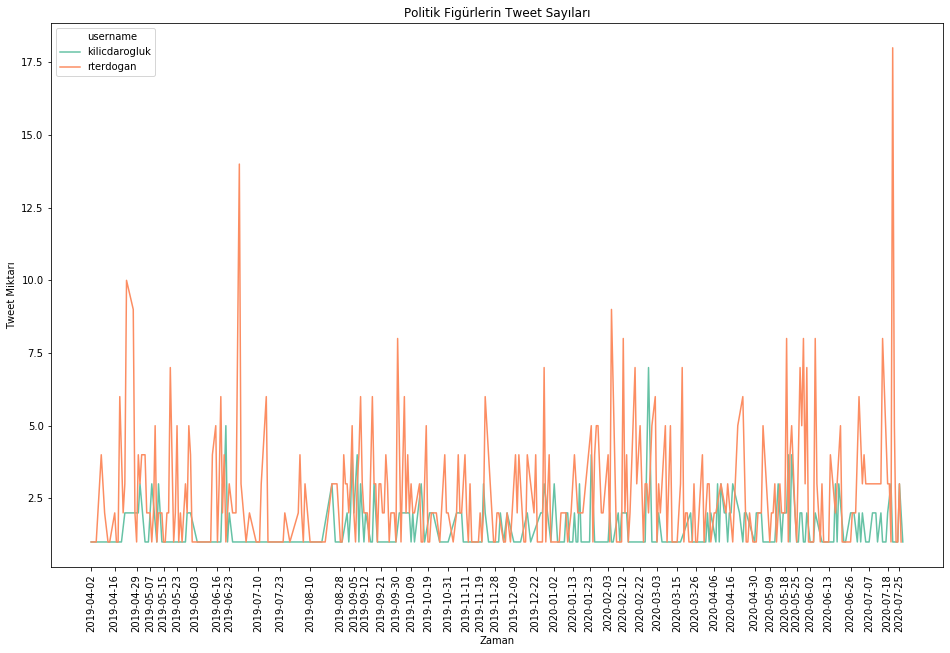

In [6]:
twt_grup = twt[["created_at", "username", "tweet_id"]].groupby(["created_at", "username"]).count().reset_index() #id kısmını sayaç olarak kullanacağız.

xticks_list = [] 
for index in np.arange(0, 588, 13):
    xticks_list.append(twt_grup.created_at.iloc[index])

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="created_at", y="tweet_id", hue="username", data=twt_grup, palette="Set2", ax=ax)
plt.xticks(xticks_list, rotation=90)
plt.title("Politik Figürlerin Tweet Sayıları")
plt.xlabel("Zaman")
plt.ylabel("Tweet Miktarı")

Tabloya baktığımızda gözümüze ilk çarpan şey Recep Tayyip Erdoğan (Turuncu renk) ile Kemal Kılıçdaroğlu'nun (Yeşil renk) Twitter aktivite sıklığındaki fark oluyor. Gözlemlenebileceği üzere, Kemal Kılıçdaroğlu'nun Twitter kullanımı çok nadiren günlük 5 Tweet'ten öteye giderken, Recep Tayyip Erdoğan gözle görülür bir farkla sosyal medya kullanımında çok daha aktif. Aynı zamanda, Kemal Kılıçdaroğlu'nun **Tweet attığı günlerde** genelde günlük 3 civarı Tweet atıyor olduğu gözlemlebilirken bunu Recep Tayyip Erdoğan için ilk bakışta hesaplamak çok mümkün görünmüyor. Recep Tayyip Erdoğan'ın Twitter aktivitesine baktığımızda içinde bulunduğumuz haftada (2020, Temmuz sonu) zirve yapmış bir dalgalanma haline rastlıyoruz. Dilerseniz her iki liderin de 1 Nisan 2019'dan bu yana günlük ortalama ne kadar tweet atmış olduklarını bir hesaplayalım:

In [7]:
rte_ortalama_günlük = twt_grup[twt_grup["username"] == "rterdogan"].tweet_id.mean()
kk_ortalama_günlük = twt_grup[twt_grup["username"] == "kilicdarogluk"].tweet_id.mean()
print("Ortalama günlük Tweet sayısı RTE için {} iken, KK için {}.".format(rte_ortalama_günlük, kk_ortalama_günlük))

Ortalama günlük Tweet sayısı RTE için 2.641337386018237 iken, KK için 1.5366795366795367.


Gördüğümüz üzere, günlük atılan ortalama Tweet sayısı Recep Tayyip Erdoğan için yaklaşık olarak 3 iken Kemal Kılıçdaroğlu için 2. Peki, her iki liderin de en çok Tweet attığı tarihlerde neler konuşulmuş? Bunu analiz etmek için Tweet içeriklerine bakacağız. 

In [8]:
rte_max_gun = list(twt_grup[twt_grup["username"] == "rterdogan"].sort_values("tweet_id", ascending=False).created_at)[0]
kk_max_gun = list(twt_grup[twt_grup["username"] == "kilicdarogluk"].sort_values("tweet_id", ascending=False).created_at)[0]
rte_tweet_icerik = twt[twt["created_at"] == rte_max_gun].tweet
kk_tweet_icerik = twt[twt["created_at"] == kk_max_gun].tweet

for i in rte_tweet_icerik:
    print("RTE: " + i)
print("\n")
for i in kk_tweet_icerik:
    print("KK: " + i)

RTE: Geçmişte en küçük sarsıntıda demokrasisiyle, ekonomisiyle, siyasi ve sosyal yapısıyla adeta yerle yeksan olan bir Türkiye’den; bölgesel ve küresel her türlü sınamayı başarıyla veren bir Türkiye’ye geldik. pic.twitter.com/NiKcYIs08t
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | KÜLTÜR ve TURİZM 🎥🏖️
#ReformİcraatDeğişim pic.twitter.com/2iYd6AWbud
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | DIŞİŞLERİ 🌐
#ReformİcraatDeğişim pic.twitter.com/qsLMI5UGyW
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | ENERJİ 💡
#ReformİcraatDeğişim pic.twitter.com/xR2sECuZLV
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | SANAYİ ve TEKNOLOJİ ⚙️
#ReformİcraatDeğişim pic.twitter.com/r5ZBqhSRI8
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | TİCARET 📦💳
#ReformİcraatDeğişim pic.twitter.com/ys7ZmPzn15
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | HAZİNE ve MALİYE 🏦📈
#ReformİcraatDeğişim pic.twitter.com/d7JeBqldBU
RTE: Cumhurbaşkanlığı Hükümet Sistemi 🇹🇷 | TARIM ve ORMAN 🌾🌲
#ReformİcraatDeğişim pic.twitter.com/OEGvUSjshu
RTE: Cumhurb

Yukarıda Recep Tayyip Erdoğan ve Kemal Kılıçdaroğlu'nun son seçimden bu yana en çok Tweet atmış oldukları günlerde attıkları Tweetleri görüyoruz. Bu verilerden çıkarımlarımız şunlar olabilir:
* Recep Tayyip Erdoğan'ın Tweetlerinden birini arattığımızda karşımıza Başkanlık Sistemi boyunca çeşitli alanlarda yapılan icraatler ile ilgili olduğunu görüyoruz.
* Kemal Kılıçdaroğlu'nun Tweetlerine baktığımızda o günün gündemi hakkında daha bilgilendirici olduklarını fark etmekteyiz.

Şimdi her iki politik figürün hashtag kullanımlarını inceleyelim.

In [9]:
rte_tags = {}
kk_tags = {}

for tag in rte_tweetleri["hashtags"]:
    if tag not in rte_tags:
        rte_tags[tag] = 1
    else:
        rte_tags[tag] += 1
        
for tag in kk_tweetleri["hashtags"]:
    if tag not in kk_tags:
        kk_tags[tag] = 1
    else:
        kk_tags[tag] += 1

print("RTE En Çok Kullanılan 5 Hashtag:")
for index, tag in enumerate(sorted(rte_tags.items(), key=lambda x:x[1], reverse=True)):
    if index in range(1, 6):
        print(tag[0] + ": " + str(tag[1]))
        
print("\nKK En Çok Kullanılan 5 Hashtag:")
for index, tag in enumerate(sorted(kk_tags.items(), key=lambda x:x[1], reverse=True)):
    if index in range(1, 6):
        print(tag[0] + ": " + str(tag[1]))

RTE En Çok Kullanılan 5 Hashtag:
['#reformi̇craatdeğişim']: 14
['#yenidenyollaradüşmevakti']: 5
['#15temmuz']: 4
['#29ekim']: 3
['#dünyaçevregünü']: 2

KK En Çok Kullanılan 5 Hashtag:
['#aydın']: 4
['#1mayıs']: 3
['#lozanbarışantlaşması']: 2
['#erzurumkongresi']: 2
['#süleymandemirel']: 2


Her iki politik figürün de yaygın kullandıkları hashtagleri yukarıda görebilirsiniz. Şimdi bu politik kişiliklerin zamanla aldıkları like sayısını görselleştirelim.

Text(0, 0.5, 'Like Miktarı')

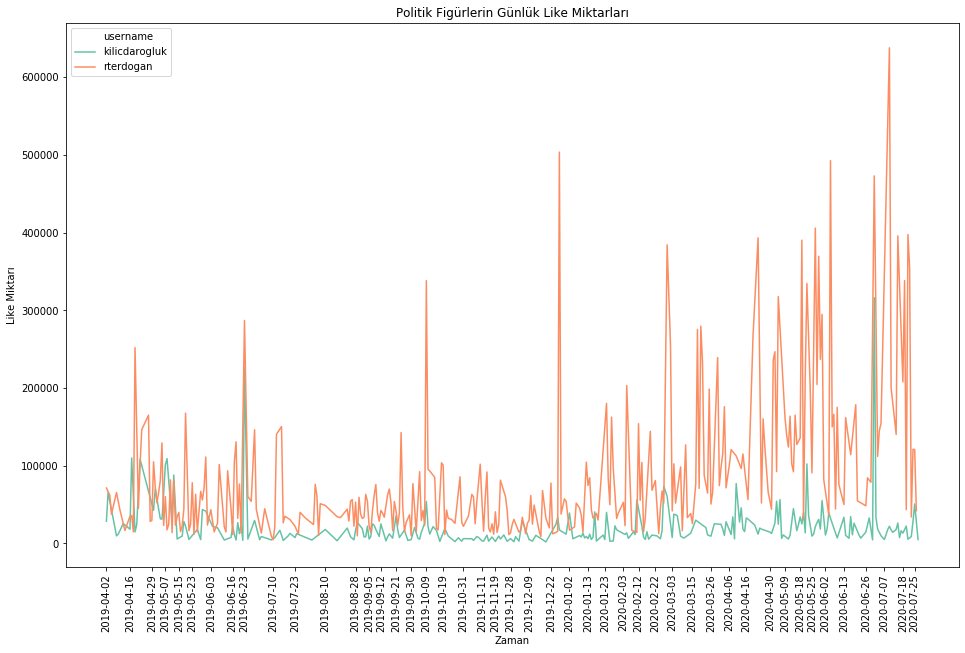

In [10]:
twt_grup_2 = twt[["created_at", "username", "likes_count"]].groupby(["created_at", "username"]).sum().reset_index() #id kısmını sayaç olarak kullanacağız.

fig1, ax1 = plt.subplots(figsize=(16,10))
sns.lineplot(x="created_at", y="likes_count", hue="username", data=twt_grup_2, palette="Set2", ax=ax1)
_ = plt.xticks(xticks_list, rotation=90)
plt.title("Politik Figürlerin Günlük Like Miktarları")
plt.xlabel("Zaman")
plt.ylabel("Like Miktarı")

Yukarıdaki tabloya baktığımızda gözümüze çarpan ilk şey Recep Tayyip Erdoğan'ın beğeni miktarının genel olarak Kemal Kılıçdaroğlu'nun beğenilerinden daha fazla olduğu. Özellikle 2020 senesine baktığımızda, Recep Tayyip Erdoğan tarafından atılan tweetlerin like sayılarının son zamanlara doğru büyük bir artış göstermiş olduğunu farkediyoruz.

Verimizi yeterince incelediğimize göre işin makine öğrenimi olan kısmına geçebiliriz.

# 4. Terim Ağırlıklandırma (Feature Weighting)

Bu adımda Tweetlerde geçen kelimelerin terim frekanslarını baz alarak verimizi makine öğrenimine hazır bir şekle getireceğiz. Bunu yaparken verilerimizi biri makine öğrenimi esnasında, diğeri ise hakkında sonraki adımda daha çok bilgi edinebileceğiniz doğruluk testi esnasında kullanılmak üzere iki bölüme ayıracağız.

In [11]:
training_data, testing_data = train_test_split(twt, random_state=1) #çalışmanın tekrarlanabilirliği için seed belirttik.

Y_train = training_data["username"].values
Y_test = testing_data["username"].values

def kelime_sayacı(sütun, training_set, testing_set):

    cv = CountVectorizer(binary=False, max_df=0.95)
    cv.fit_transform(training_data[sütun].values)
    
    train_feature_set = cv.transform(training_data[sütun].values)
    test_feature_set = cv.transform(testing_data[sütun].values)
    
    return train_feature_set, test_feature_set, cv

X_train, X_test, feature_transformer = kelime_sayacı("tweet", training_data, testing_data)

# 5. Lojistik Regresyon

Bu kısımda ise hazırlamış olduğumuz veriler ile önce modelimizi eğiteceğiz, sonrasında test edip Tweet sahibini ne oranda doğru tahmin edebiliyor ona bakacağız. Test için metrik olarak "Accuracy Score" kullanacağız. Bu metriğin hesaplanması şu şekilde yapılır:

\begin{equation}
\text{Accuracy Score} = \frac{\text{Doğru Tahminlerin Sayısı}}{\text{Toplam Tahminlerin Sayısı}}
\end{equation}

In [12]:
classifier = LogisticRegression(solver="newton-cg", C=5, penalty="l2", multi_class="multinomial", max_iter=1000)
model = classifier.fit(X_train, Y_train)

In [13]:
predictions = model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions, normalize=True)
print("Modelimizin doğruluğu yaklaşık olarak {}% oranındadır.".format(round(accuracy, 2) * 100))

Modelimizin doğruluğu yaklaşık olarak 89.0% oranındadır.


# 6. Sonuç

### Bu projede 04.01.2019 tarihinden bu yana (27.07.2020) iki popüler politik lider tarafından atılan Twitter gönderilerini inceledik. Son aşamada ise metin sınıflandırma işlemlerinde sıkça kullanılan Lojistik Regresyon modelimizi eğittik ve 89% oranında doğru tahminler elde ettik.